In [1]:
# pip install numpy pandas matplotlib ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt

fatal: bad revision 'HEAD'


In [2]:
fast_sma_window = 50
slow_sma_window = 200

# ! I just coded the long-only version, but including short is very similar !

# Top 10 Marketcap -> https://coinmarketcap.com/

# Symbol Naming Conventions -> https://github.com/ccxt/ccxt/wiki/Manual#contract-naming-conventions
# BTC/USDT -> spot
# BTC/USDT -> perp USDT
# BTC/USDT:BTC -> perp coin
# BTC/USDC:USDC -> perp USDC

symbols = ["BTC/USDT", "ETH/USDT", "BNB/USDT", "SOL/USDT", "XRP/USDT",
           "AVAX/USDT", "DOGE/USDT", "ADA/USDT", "TRX/USDT", "SHIB/USDT"]

plot_benchmark = True

since = "01/01/2017"
timeframe = "1d"
fee = 0.0001

exchange = ccxt.binance()

In [3]:
from datetime import datetime

def date_to_milliseconds(date_string):
    date_format = "%d/%m/%Y"
    date = datetime.strptime(date_string, date_format)
    milliseconds = int(date.timestamp() * 1000)
    return milliseconds

since_millis = date_to_milliseconds(since)
print(since, since_millis)

01/01/2017 1483228800000


In [4]:
ohlcv_columns = ["timestamp", "open", "high", "low", "close", "volume"]

def fetch_raw_ohlcvs(symbols):
    raw_ohlcvs = {}
    for symbol in symbols:
        price_date = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=0, params={"paginate": True})
        
        ohlcv = pd.DataFrame(price_date, columns=ohlcv_columns)
        ohlcv["timestamp"] = pd.to_datetime(ohlcv["timestamp"], unit="ms")
        ohlcv = ohlcv.set_index("timestamp")
        
        raw_ohlcvs[symbol] = ohlcv

    return raw_ohlcvs

raw_ohlcvs = fetch_raw_ohlcvs(symbols)
raw_ohlcvs

{'BTC/USDT':                 open      high       low     close        volume
 timestamp                                                       
 2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377
 2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264
 2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763
 2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022
 2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060
 ...              ...       ...       ...       ...           ...
 2024-06-23  64262.01  64521.00  63178.32  63210.01   8224.454470
 2024-06-24  63210.01  63369.80  58402.00  60293.30  52161.354140
 2024-06-25  60293.30  62420.00  60257.06  61806.01  31189.243610
 2024-06-26  61806.01  62487.81  60712.00  60864.99  22485.664630
 2024-06-27  60864.98  61455.15  60606.63  61258.48   7815.208270
 
 [2507 rows x 5 columns],
 'ETH/USDT':                open     high      low    close        volume
 timestamp                  

In [5]:
raw_ohlcvs["BTC/USDT"]

,open,high,low,close,volume
timestamp,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2024-06-23,64262.01,64521.00,63178.32,63210.01,8224.454470
2024-06-24,63210.01,63369.80,58402.00,60293.30,52161.354140
2024-06-25,60293.30,62420.00,60257.06,61806.01,31189.243610


In [6]:
def calc_features(ohlcvs):
    for symbol, ohlcv in ohlcvs.items():
        fast_sma = ohlcv['close'].rolling(window=fast_sma_window).mean()
        slow_sma = ohlcv['close'].rolling(window=slow_sma_window).mean()

        ohlcvs[symbol]["sma_cross_up"] = np.where((fast_sma > slow_sma) & (fast_sma.shift(1) < slow_sma.shift(1)), True, False)
        ohlcvs[symbol]["sma_cross_down"] = np.where((fast_sma < slow_sma) & (fast_sma.shift(1) > slow_sma.shift(1)), True, False) # slow crosses over fast sma

        ohlcvs[symbol]["fast_sma"] = fast_sma
        ohlcvs[symbol]["slow_sma"] = slow_sma

        # We add a in_position column to keep track of the position
        ohlcvs[symbol]["in_position"] = False

    return ohlcvs

ohlcvs = calc_features(raw_ohlcvs)
ohlcvs

{'BTC/USDT':                 open      high       low     close        volume  \
 timestamp                                                          
 2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
 2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
 2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
 2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022   
 2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
 ...              ...       ...       ...       ...           ...   
 2024-06-23  64262.01  64521.00  63178.32  63210.01   8224.454470   
 2024-06-24  63210.01  63369.80  58402.00  60293.30  52161.354140   
 2024-06-25  60293.30  62420.00  60257.06  61806.01  31189.243610   
 2024-06-26  61806.01  62487.81  60712.00  60864.99  22485.664630   
 2024-06-27  60864.98  61455.15  60606.63  61258.48   7815.208270   
 
             sma_cross_up  sma_cross_down    fast_sma     slow_sma  in_position  
 timest

In [7]:
ohlcv_btc = ohlcvs["BTC/USDT"]

ohlcv_btc["sma_cross_up"][ohlcv_btc["sma_cross_up"] == True]

timestamp
2019-04-24    True
2020-02-18    True
2020-05-21    True
2021-09-15    True
2023-02-07    True
2023-10-30    True
Name: sma_cross_up, dtype: bool

In [8]:
ohlcv_btc["sma_cross_down"][ohlcv_btc["sma_cross_down"] == True]

timestamp
2018-03-31    True
2019-10-26    True
2020-03-25    True
2021-06-19    True
2022-01-14    True
2023-09-12    True
Name: sma_cross_down, dtype: bool

In [9]:
def backtest():
    ohlcv = ohlcv_btc.dropna()

    open_position = {}
    closed_trades = []

    for index, row in ohlcv.iterrows():
        if row["sma_cross_up"] and not open_position:
            open_position = {
                "entry_date": index,
                "entry_price": row["close"],
                "fee": fee
            }

            ohlcv.at[index, "in_position"] = True

        elif row["sma_cross_down"] and open_position:
            open_position["exit_date"] = index
            open_position["exit_price"] = row["close"]
            open_position["fee"] += fee

            open_position["pnl"] = open_position["exit_price"] / open_position["entry_price"] - 1 - open_position["fee"]

            closed_trades.append(open_position)
            open_position = {}

            # Set "in_position" to True for the current row and False for the next row
            ohlcv.at[index, "in_position"] = True
            current_loc = ohlcv.index.get_loc(index)
            if current_loc < len(ohlcv) - 1:
                next_index = ohlcv.index[current_loc + 1]
                ohlcv.at[next_index, "in_position"] = False

        else:
            ohlcv.at[index, "in_position"] = bool(open_position)

    return closed_trades, ohlcv["in_position"]

closed_trades, in_position_array = backtest()

In [10]:
in_position_array

timestamp
2018-03-04    False
2018-03-05    False
2018-03-06    False
2018-03-07    False
2018-03-08    False
              ...  
2024-06-23     True
2024-06-24     True
2024-06-25     True
2024-06-26     True
2024-06-27     True
Name: in_position, Length: 2308, dtype: bool

In [11]:
closed_trades_df = pd.DataFrame(closed_trades)
closed_trades_df

,entry_date,entry_price,fee,exit_date,exit_price,pnl
0,2019-04-24,5415.00,0.0002,2019-10-26,9230.00,0.704324
1,2020-02-18,10164.71,0.0002,2020-03-25,6677.43,-0.343277
2,2020-05-21,9068.65,0.0002,2021-06-19,35483.72,2.912590
3,2021-09-15,48121.41,0.0002,2022-01-14,43059.96,-0.105381
4,2023-02-07,23240.46,0.0002,2023-09-12,25840.10,0.111658


In [12]:
realised_returns = closed_trades_df[["exit_date", "pnl"]]
realised_returns = realised_returns.set_index("exit_date")
realised_returns["comp_pnl"] = (realised_returns["pnl"] + 1).cumprod() - 1

realised_returns

,pnl,comp_pnl
exit_date,,
2019-10-26,0.704324,0.704324
2020-03-25,-0.343277,0.119269
2021-06-19,2.912590,3.379239
2022-01-14,-0.105381,2.917752
2023-09-12,0.111658,3.355201


In [13]:
unrealised_returns = pd.concat([ohlcv_btc["close"], in_position_array], axis=1)
unrealised_returns["pct_change"] = unrealised_returns["close"].pct_change()
unrealised_returns = unrealised_returns.dropna()
unrealised_returns["pnl"] = np.where(unrealised_returns["in_position"], unrealised_returns["pct_change"], 0)
unrealised_returns["comp_pnl"] = (unrealised_returns["pnl"] + 1).cumprod() - 1
unrealised_returns

,close,in_position,pct_change,pnl,comp_pnl
timestamp,,,,,
2018-03-04,11515.00,False,0.004407,0.000000,0.000000
2018-03-05,11454.00,False,-0.005297,0.000000,0.000000
2018-03-06,10716.48,False,-0.064390,0.000000,0.000000
2018-03-07,9910.00,False,-0.075256,0.000000,0.000000
2018-03-08,9271.64,False,-0.064416,0.000000,0.000000
...,...,...,...,...,...
2024-06-23,63210.01,True,-0.016370,-0.016370,7.191837
2024-06-24,60293.30,True,-0.046143,-0.046143,6.813840
2024-06-25,61806.01,True,0.025089,0.025089,7.009883


In [14]:
def calculate_DD(returns):
    """
    Calculates various drawdown metrics, such as maximum drawdown, maximum drawdown duration, date of maximum drawdown, average drawdown and drawdown array
    based on the provided returns.
    """
    returns = returns.dropna()

    cum_returns = returns.cumsum()

    highwatermark = np.zeros(cum_returns.shape)
    drawdown = np.zeros(cum_returns.shape)
    drawdown_duration = np.zeros(cum_returns.shape)
    
    for t in np.arange(1, len(cum_returns)):
        highwatermark[t] = np.maximum(highwatermark[t-1], cum_returns.iloc[t])
        drawdown[t] = (1 + cum_returns.iloc[t]) / (1 + highwatermark[t]) - 1
        
        if drawdown[t] == 0:
            drawdown_duration[t] = 0
        else:
            drawdown_duration[t] = drawdown_duration[t-1] + 1

    maxDD = np.min(drawdown)
    avgDD = np.mean(drawdown)
    i = np.argmin(drawdown)
    maxDDD = np.max(drawdown_duration)
    
    return maxDD, maxDDD, avgDD, returns.index[i], drawdown

In [15]:
def show_stats(returns: pd.DataFrame, cum_returns: pd.DataFrame) -> dict:
    """
    Computes and displays various trading statistics, such as average trade returns, win rate, PnL, drawdowns,
    and other performance metrics, based on the provided returns.
    """
    maxDD, maxDDD, avgDD, maxDD_date, _ = calculate_DD(returns)

    stats = {
        "Avg Trade Return": returns.mean(),
        "Avg Positive Trade Return": returns[returns >= 0].mean(),
        "Avg Negative Trade Return": returns[returns < 0].mean(),
        "Win Rate": len(returns[returns >= 0]) / len(returns),
        "PnL (%)": cum_returns.iloc[-1] * 100,
        "Max Drawdown": maxDD,
        "Max Drawdown Duration": maxDDD,
        "Max Drawdown Date": maxDD_date,
        "Avg Drawdown": avgDD
    }
    
    return stats

show_stats(unrealised_returns["pnl"], unrealised_returns["comp_pnl"])

{'Avg Trade Return': np.float64(0.0012626225536023054),
 'Avg Positive Trade Return': np.float64(0.009334043064860645),
 'Avg Negative Trade Return': np.float64(-0.022674270577723973),
 'Win Rate': 0.7478336221837089,
 'PnL (%)': np.float64(693.8924409302484),
 'Max Drawdown': np.float64(-0.4256287436080851),
 'Max Drawdown Duration': np.float64(999.0),
 'Max Drawdown Date': Timestamp('2020-03-12 00:00:00'),
 'Avg Drawdown': np.float64(-0.08432781362397404)}

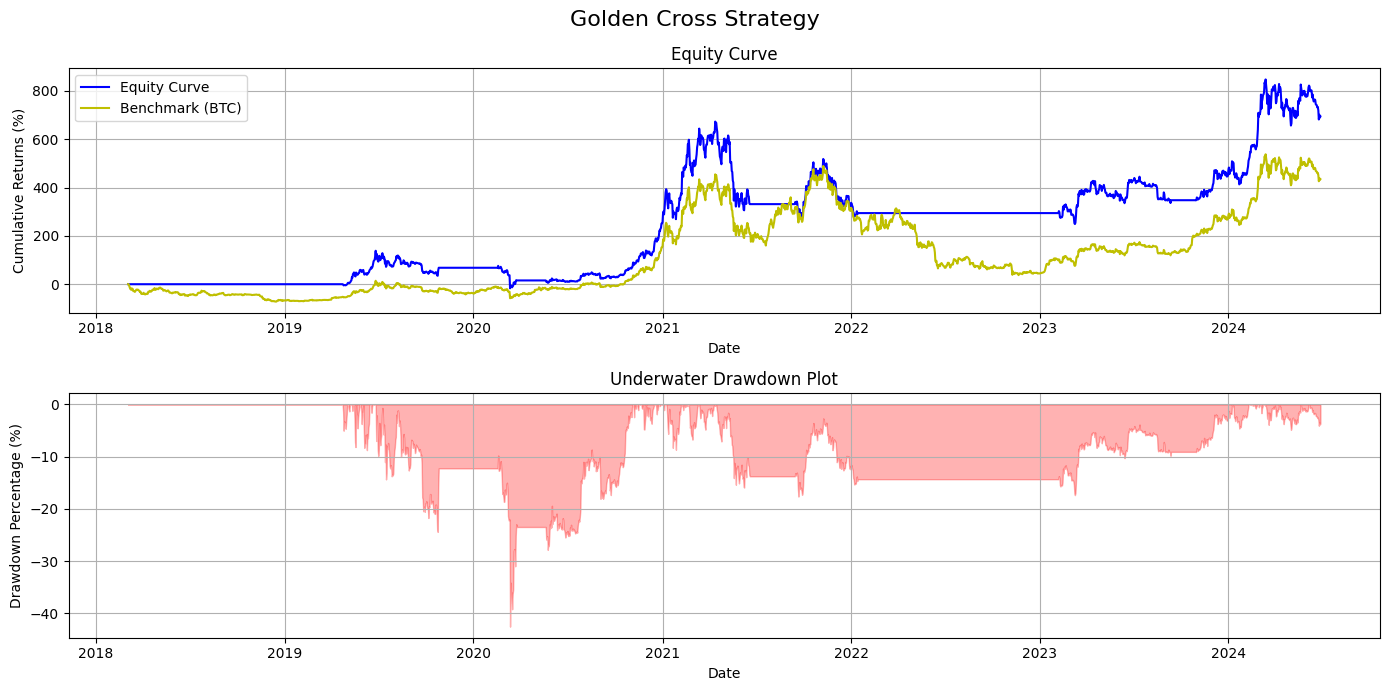

In [16]:
def plot_returns(returns: pd.DataFrame, comp_returns: pd.DataFrame):
    """
    Plots the equity curve, underwater drawdown, and benchmark (if applicable) for the given returns.
    """
    _, _, _, _, drawdown = calculate_DD(returns)

    start_date = comp_returns.index[0]

    if plot_benchmark:
        benchmark_pnl = ohlcv_btc["close"].pct_change()
        benchmark_pnl = benchmark_pnl[start_date:]
        benchmark_comp_pnl = (benchmark_pnl + 1).cumprod() - 1
        benchmark_percentages = benchmark_comp_pnl * 100
    
    cum_returns_percentages = comp_returns * 100
    drawdown_percentages = drawdown * 100
    
    plt.figure(figsize=(14, 7))

    # Equity curve
    plt.subplot(2, 1, 1)
    plt.plot(cum_returns_percentages, label="Equity Curve", color="b")
    if plot_benchmark:
        plt.plot(benchmark_percentages, label="Benchmark (BTC)", color="y")
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns (%)")
    plt.legend()
    plt.grid(True)

    # Drawdown
    plt.subplot(2, 1, 2)
    plt.fill_between(cum_returns_percentages.index, 0, drawdown_percentages, color="red", alpha=0.3)
    plt.title("Underwater Drawdown Plot")
    plt.xlabel("Date")
    plt.ylabel("Drawdown Percentage (%)")
    plt.grid(True)

    plt.suptitle(f"Golden Cross Strategy", fontsize=16)
    
    plt.tight_layout()
    plt.show()

plot_returns(unrealised_returns["pnl"], unrealised_returns["comp_pnl"])

In [17]:
# export closed_trades & compare with TradingView
closed_trades_df.to_csv("closed_trades.csv")